<a href="https://colab.research.google.com/github/ankita-sen09/sentiment-analysis/blob/main/sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


(30176, 40)
(30176, 40)


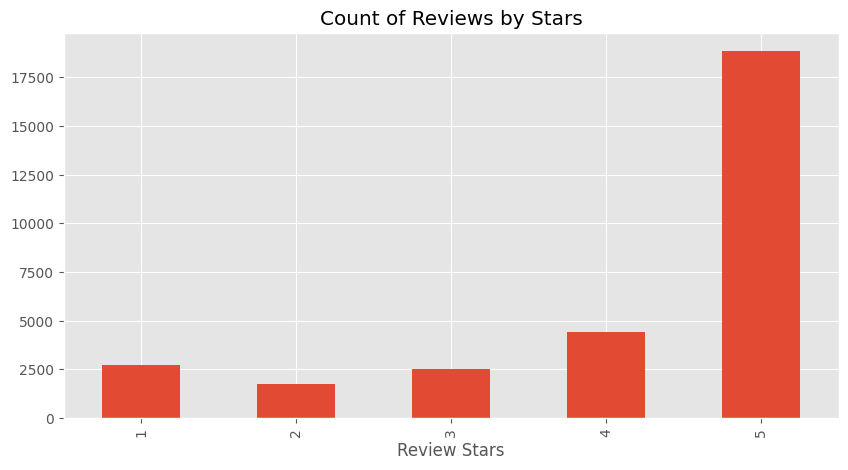

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use('ggplot')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

# Handle file reading errors and provide feedback
try:
    df = pd.read_csv('/content/Reviews.csv', encoding='utf-8', engine='python', on_bad_lines='skip')
    df.head()
except pd.errors.ParserError as e:
    print(f"An error occurred while reading the file: {e}")
except FileNotFoundError:
    print("The specified file was not found.")
else:  # Execute the following code only if no exceptions occurred
    df['Text'].values[0]
    print(df.shape)
    df.head(500)
    print(df.shape)
    ax=df['Score'].value_counts().sort_index().plot(kind='bar',title='Count of Reviews by Stars',figsize=(10,5))
    ax.set_xlabel('Review Stars')
    plt.show()
    example=df['Text'][50]
    print(example)
    tokens=nltk.word_tokenize(example)
    tokens[0:10]





In [5]:
tokens=nltk.word_tokenize(example)
tokens[0:10]
tagged=nltk.pos_tag(tokens)
tagged[:10]
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()


(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sia= SentimentIntensityAnalyzer()
sia.polarity_scores('I loved it so much!')
sia.polarity_scores('This is bad')

{'neg': 0.636, 'neu': 0.364, 'pos': 0.0, 'compound': -0.5423}

In [7]:
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text=row['Text']
  myid=row['ProductId']
  res[myid]=sia.polarity_scores(text)


  0%|          | 0/30176 [00:00<?, ?it/s]

In [8]:
vaders=pd.DataFrame(res).T

In [9]:
vaders=vaders.reset_index().rename(columns={'index':'ProductId'})
vaders=vaders.merge(df,how='left', on='ProductId')
vaders.head()

,ProductId,neg,neu,pos,compound,1,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,...,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,B001E4KFG0,0.000,0.695,0.305,0.9441,1,A3SGXH7AUHU8GW,delmartian,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B00813GRG4,0.138,0.862,0.000,-0.5664,2,A1D87F6ZCVE5NK,dll pa,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B000LQOCH0,0.091,0.754,0.155,0.8265,3,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B000UA0QIQ,0.000,1.000,0.000,0.0000,4,A395BORC6FGVXV,Karl,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,B006K2ZZ7K,0.000,0.520,0.480,0.9487,5,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


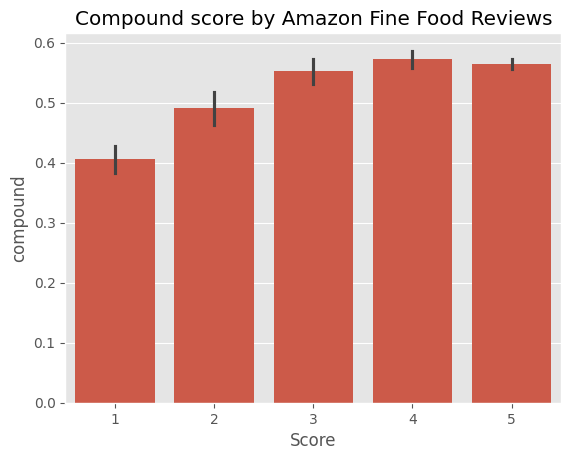

In [10]:
ax=sns.barplot(data=vaders,x='Score',y='compound')
ax.set_title('Compound score by Amazon Fine Food Reviews')
plt.show()

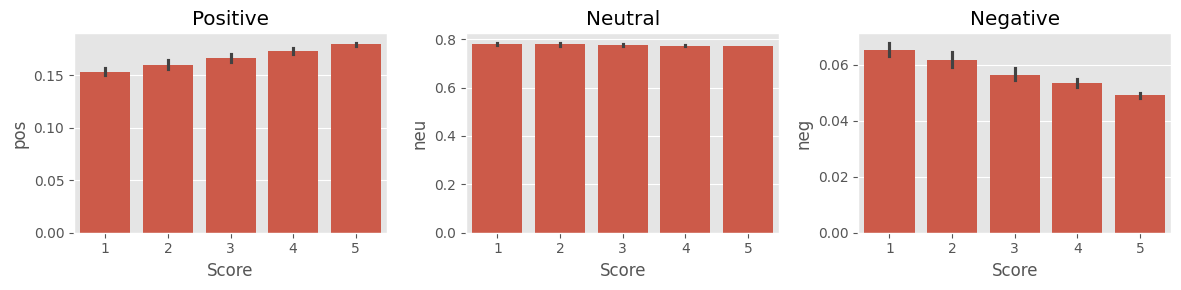

In [11]:
fig, axs= plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='pos', ax=axs[0])
sns.barplot(data=vaders,x='Score',y='neu', ax=axs[1])
sns.barplot(data=vaders,x='Score',y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()


In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [13]:
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687465, 'roberta_pos': 0.0029573692}


In [14]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:

from tqdm import tqdm # Import the tqdm module

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['ProductId']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 82/30176 [00:29<1:48:51,  4.61it/s]

Broke for id B003ZFRKGO


  1%|          | 188/30176 [01:08<1:41:11,  4.94it/s]

Broke for id B000NY8ODS


  2%|▏         | 528/30176 [03:16<3:56:32,  2.09it/s]

Broke for id B000G6RYNE


  2%|▏         | 539/30176 [03:20<3:09:18,  2.61it/s]

Broke for id B000G6RYNE


  2%|▏         | 745/30176 [04:44<4:55:58,  1.66it/s]

Broke for id B001LO4ZWI


  3%|▎         | 864/30176 [05:28<2:02:51,  3.98it/s]

Broke for id B000VKYKTG


  3%|▎         | 1052/30176 [06:43<3:31:39,  2.29it/s]

Broke for id B001TZSDJK


  4%|▎         | 1069/30176 [06:50<2:25:19,  3.34it/s]

Broke for id B001QXUTLU


  4%|▍         | 1157/30176 [07:22<1:31:17,  5.30it/s]

Broke for id B004134H9W


  4%|▍         | 1320/30176 [08:24<2:59:37,  2.68it/s]

Broke for id B004EKO2HE


  5%|▍         | 1374/30176 [08:43<5:37:44,  1.42it/s]

Broke for id B00068PCTU


  5%|▍         | 1497/30176 [09:32<2:05:50,  3.80it/s]

Broke for id B002KGN4LE


  5%|▌         | 1574/30176 [10:03<5:44:38,  1.38it/s]

Broke for id B001CWZXIY


  6%|▌         | 1797/30176 [11:25<1:11:04,  6.65it/s]

Broke for id B001RVFDOO


  6%|▌         | 1827/30176 [11:36<2:12:41,  3.56it/s]

Broke for id B001RVFDOO


  6%|▋         | 1888/30176 [12:02<2:26:34,  3.22it/s]

In [16]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')
results_df.columns

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False

KeyError: 'Score'

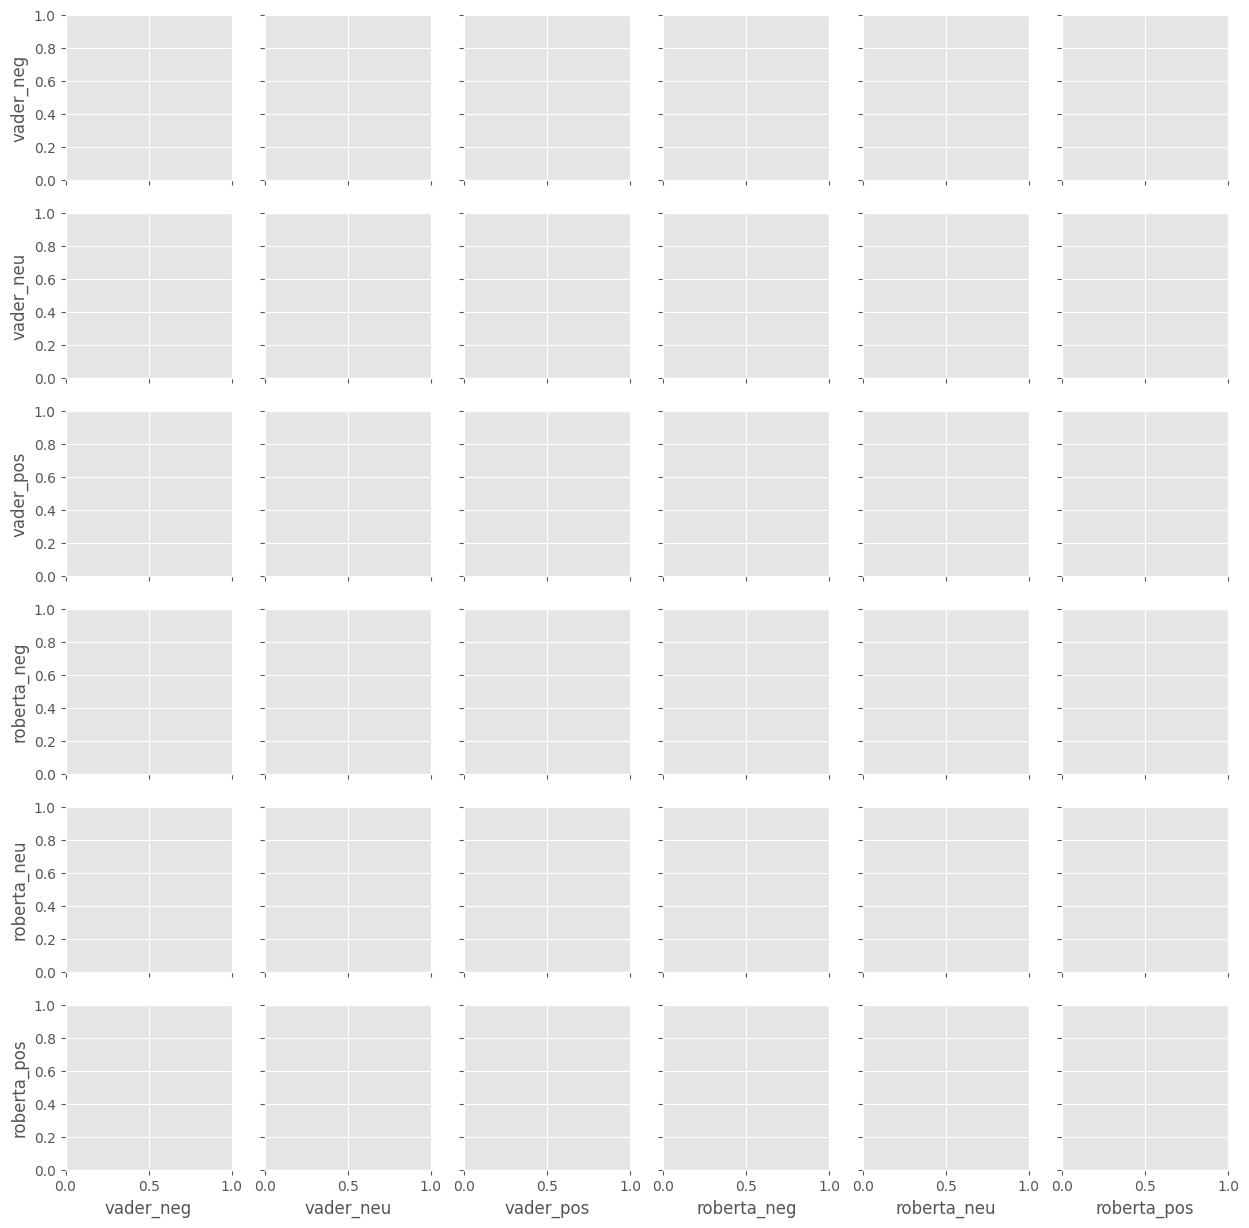

In [17]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [ ]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

In [18]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

UndefinedVariableError: name 'Score' is not defined

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('booo')